In [47]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.signal import medfilt

################################################subtract noise diode signal#####################################################
def noise_onoff(num,ttbin=1,file=0,filelen=512*1024,tperiod=80*1024,tnoise=5*1024):  
    # default: noise diode signals are periodically injected. e.g. on-1s off-15s on-1s off-15s ......   
    # To determine the index of 'num'th cycle of noise 'on' and noise 'off'
    # noise 'on': noise_on[0] - noise_on[1]   noise 'off': noise_off[0] - noise_off[1]
    # num: the sequence number of the cycle in the fits file. cycle starts with the noise injection
    # ttbin: first round of time rebin. default 1
    # file: the sequence number of the fits file. default 0
    # filelen: the length of a single file in time domain. default 512*1024
    # tperiod: the length of the cycle period. default 80*1024
    # tnoise: the length of the noise injection time. default 5*1024
    # the default value of tinterval and tnoise accords to the noise injection mode: 1s noise every 16s, time cadence 0.2ms
    tperiod=tperiod//ttbin
    tnoise=tnoise//ttbin
    prelen=filelen//ttbin*file
    prenum=int(np.ceil(prelen/tperiod))              # the number of previous cycles
    num=num+prenum                    # the real sequence number of the cycle
    noise_on=[num*tperiod-prelen,num*tperiod+tnoise-prelen]
    noise_off=[num*tperiod+tnoise-prelen,num*tperiod+2*tnoise-prelen]
    return noise_on,noise_off

def noise_count(file=0,currlen=512*1024,filelen=512*1024,tperiod=80*1024,tnoise=5*1024):
    # count the number of noise diode signals in a file
    prelen=filelen*file
    n_start=np.ceil(prelen/tperiod)
    n_end=np.ceil((prelen+currlen)/tperiod)
    return int(n_end-n_start)

################################################polarization and flux calibration#############################################
def obs2true(I,Q,U,V,gamma=0,phi=0,au2t=1):
    # calibrate the observed flux in four Stokes parameters
    # reference:  Britton (2000), van Straten (2004), Liao et al. (2016)
    I2=I*np.cosh(2*gamma)-Q*np.sinh(2*gamma)
    Q2=-I*np.sinh(2*gamma)+Q*np.cosh(2*gamma)
    U2=U*np.cos(2*phi)-V*np.sin(2*phi)
    V2=U*np.sin(2*phi)+V*np.cos(2*phi)
    return I2*au2t,Q2*au2t,U2*au2t,V2*au2t

def diff_cal(I,Q,U,V,noise_T=12.5*np.ones(1024)):
    # determine the differential gain and phase of the orthogonal feeds using the noise diode signals
    # calculate /gamma and /phi value in Mueller matrix
    # reference:  Britton (2000), van Straten (2004), Liao et al. (2016)
    gamma=np.arctanh(Q/I)/2
    phi=np.angle(U-V*complex(0,1))/2
    I2=I*np.cosh(2*gamma)-Q*np.sinh(2*gamma)
    return gamma,phi,noise_T/I2

def read_dat(datfile):
    # read data array from .dat file
    datstr = np.genfromtxt(datfile,delimiter='\t',dtype=str)
    datdata=[]
    for linestr in datstr:
        tmp=linestr.split(' ')
        while '' in tmp:
            tmp.remove('')
        for num in tmp:
            datdata.append(float(num))
     
    return datdata

def give_noise_T(adat,bdat,freqdat,freq):
    # derive the noise temperature from the .dat file
    # .dat files can be downloaded from the noise diode calibration report
    # (https://fast.bao.ac.cn/cms/category/telescope_performance/noise_diode_calibration_report/)
    # T_noise=np.sqrt(T_A*T_B)
    datstr = np.genfromtxt(adat,delimiter='\t',dtype=str)
    adatdata=read_dat(adat)
    bdatdata=read_dat(bdat)
    freqdatdata=read_dat(freqdat)
    raw_T=np.sqrt(np.array(adatdata)*np.array(bdatdata))
    raw_freq=np.array(freqdatdata)
    return np.interp(freq,raw_freq,raw_T)

################################################data concat and reduction####################################################
def concatdata(data,pol):
    # concatenate data in the given polarization
    # input data dimension time time pol freq 0   512 1024 4 1024 1
    # output data dimension time freq  512*1024 1024
    # notice that the raw data is in the format of uint8, better change to int
    # polarization channels are XX YY CR CI, CR=Re{XY}, CI=Im{XY}
    # Stokes parameters are defined as I=XX+YY, Q=XX-YY, U=CR*2, V=CI*2
    if pol=="XX":
        return np.int16(np.concatenate(data['data'][:,:,0,:,0]))
    elif pol=="YY":
        return np.int16(np.concatenate(data['data'][:,:,1,:,0]))
    elif pol=="CR":
        return np.int16(np.concatenate(data['data'][:,:,2,:,0]))
    elif pol=="CI":
        return np.int16(np.concatenate(data['data'][:,:,3,:,0]))
    elif pol=="I":
        return np.int16(np.concatenate(data['data'][:,:,0,:,0]))+np.int16(np.concatenate(data['data'][:,:,1,:,0]))
    elif pol=="Q":
        return np.int16(np.concatenate(data['data'][:,:,0,:,0]))-np.int16(np.concatenate(data['data'][:,:,1,:,0]))
    elif pol=="U":
        return np.int16(np.concatenate(data['data'][:,:,2,:,0]))*2
    elif pol=="V":
        return np.int16(np.concatenate(data['data'][:,:,3,:,0]))*2
    
def give_sp(filedata,ttbin):
    # obtain four Stokes parameters from filedata
    I_data=trebin(concatdata(filedata,"I"),ttbin)
    Q_data=trebin(concatdata(filedata,"Q"),ttbin)
    U_data=trebin(concatdata(filedata,"U"),ttbin)
    V_data=trebin(concatdata(filedata,"V"),ttbin)
    return [I_data, Q_data, U_data, V_data]
    
def trebin(data,ttbin):
    # rebin data in time dimension
    # data dimension time freq
    if ttbin==1:
        return data
    else:
        sz=np.shape(data)
        data2=np.zeros([sz[0]//ttbin,sz[1]])
        for i in range(sz[0]//ttbin):
            data2[i,:]=np.mean(data[ttbin*i:ttbin*(i+1),:],axis=0)
        return data2

def frebin(data,ffbin):
    # rebin data in freq dimension
    # data dimension time freq
    if ffbin==1:
        return data
    else:
        sz=np.shape(data)
        data2=np.zeros([sz[0],sz[1]//ffbin])
        for i in range(sz[1]//ffbin):
            data2[:,i]=np.mean(data[:,ffbin*i:ffbin*(i+1)],axis=1)
        return data2

################################################give timelist and freqlist######################################################
def give_time(tbin=0.000196608,ttbin=1,ttbin2=1,length=512*1024,prelength=512*1024,file=0):
    # give time list in s
    # tbin: time interval in s
    # ttbin: first round of time rebin
    # ttbin2: second round of time rebin
    # length: the length of the current file in time domain
    # prelength: the length of the previous files in time domain
    num=length//ttbin//ttbin2
    pretime=prelength*file*tbin
    return pretime+tbin*ttbin*ttbin2*np.linspace(0,num-1,num)

def give_freq(ffbin,freqlist=np.linspace(1000,1000+1023*0.48828125,1024),length=1024):
    # give frequency list in MHz
    # ffbin: frequency rebin
    # length: the length of the current file in frequency domain
    # freqlist: the raw frequency list. can be derived from 'filedata[0]['DAT_FREQ']'
    num=length//ffbin
    return np.array([np.mean(freqlist[ffbin*i:ffbin*(i+1)]) for i in range(num)])

################################################remove background##############################################################
def trend_remove(dspec,method='fit',index=1,average=1):
    # remove the long-term background flux variation
    # two methods available
    # 'fit' method (recommended): use polynomial fitting to determine the background. 
    # linear fitting only works for short period (~2 min)
    # index: the index of the polynomial fitting
    # 'startend' method: draw a line between the start and end points to estimate the background
    # average: the averaging length
    sz=np.shape(dspec)
    dspec_new=np.zeros([sz[0],sz[1]])
    for freqi in range(sz[1]):
        lc=dspec[:,freqi]
        if method == 'startend':
            y0=np.mean(lc[range(average)])
            x0=0.5*(0+average-1)
            y1=np.mean(lc[range(sz[0]-average,sz[0])])
            x1=0.5*(sz[0]-average+sz[0]-1)
            k=(y1-y0)/(x1-x0)
            dspec_new[:,freqi]=lc-k*(np.arange(sz[0])-x0)-y0
        elif method == 'fit':
            kb=np.polyfit(np.arange(sz[0]),lc,index)
            f1=np.poly1d(kb)
            dspec_new[:,freqi]=lc-f1(np.arange(sz[0]))
    return dspec_new

def fluct_remove(dspec,method='freqwin',freqwin=[],average=1):
    # remove the random broadband flux fluctuation of Stokes I
    # three methods available
    # 'win' method: choose a certain quiet spectral window as background
    # 'min' method: choose the frequency channels with the smallest flux and do averaging
    # 'winmin' method: combine the two methods above
    sz=np.shape(dspec)
    dspec_new=np.zeros([sz[0],sz[1]])
    for timeri in range(sz[0]):
        spec=np.array(dspec[timeri,:])
        if method=='win':
            dspec_new[timeri,:]=np.array(dspec[timeri,:])-np.nanmean(spec[freqwin[0]:freqwin[1]])
        elif method=='min':
            spec=np.sort(spec)
            spec = spec[np.isfinite(spec)]
            dspec_new[timeri,:]=np.array(dspec[timeri,:])-np.mean(spec[0:average-1])
        elif method=='winmin':
            spec=spec[freqwin[0]:freqwin[1]]
            spec=np.sort(spec)
            spec = spec[np.isfinite(spec)]
            dspec_new[timeri,:]=np.array(dspec[timeri,:])-np.mean(spec[0:average-1])
    return dspec_new

def sys_T(za,p0,p1,p2,n):
    return p0*np.arctan(np.sqrt(1+za**n)-p1)+p2

def give_sys_T(za,freq):
    refreq=[1050,1100,1150,1200,1250,1300,1350,1400,1450]
    p0=[4.94,5.83,4.36,4.24,4.35,3.60,3.10,2.76,2.00]
    p1=[9.12,8.75,7.53,7.75,6.88,9.88,10.03,10.00,11.93]
    p2=[26.31,28.14,26.89,27.19,25.54,24.59,23.91,23.47,22.23]
    n=[1.37,1.34,1.26,1.27,1.21,1.41,1.43,1.42,1.53]
    T=[]
    for i in range(9):
        T.append(sys_T(za,p0[i],p1[i],p2[i],n[i]))
    return np.interp(freq,refreq,T)

In [48]:
date='1203'
file_dir="/Users/jiale/.mounty/Elements/PT2021_0019/"+date+"/"

filei=2
filename=file_dir+"3C286_arctracking-M01_"+str(filei+1).zfill(4)+".fits"
file=fits.open(filename)
header = file[0].header
filedata = file[1].data
ttbin=1024
[I_data,Q_data,U_data,V_data]=give_sp(filedata,ttbin)

cal_dir=file_dir+'high/'
noise_T=give_noise_T(cal_dir+'T_noise_W_high_01a.dat',cal_dir+'T_noise_W_high_01b.dat',cal_dir+'freq.dat',filedata[0]['DAT_FREQ'])

/var/folders/1_/z6r09nlj3wsf537lkrmrs2r00000gn/T/ipykernel_5142/3743102336.py:49: RuntimeWarning: invalid value encountered in arctanh
  gamma=np.arctanh(Q/I)/2


Text(0.5, 1.0, 'Gain')

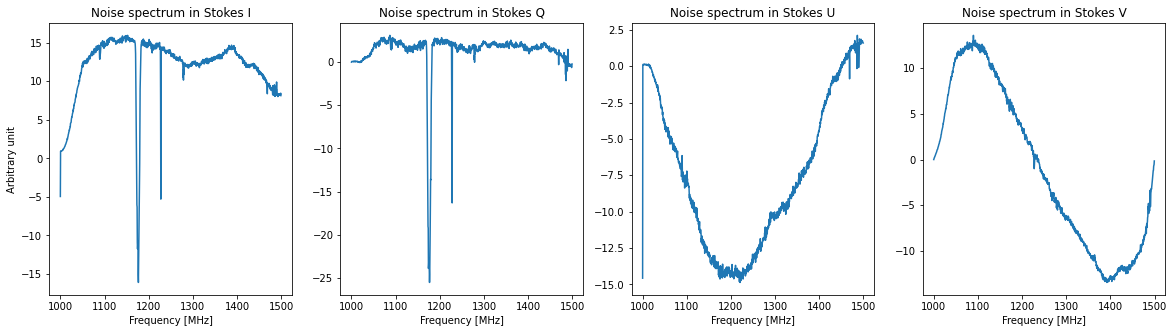

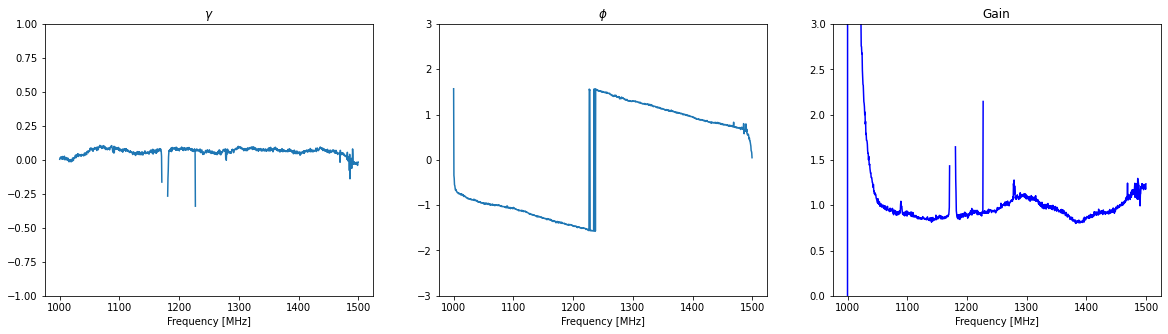

In [49]:
szdata=np.shape(I_data)
noise_num=noise_count(file=filei,currlen=szdata[0]*ttbin)
I_spec=np.zeros(szdata[1])
Q_spec=np.zeros(szdata[1])
U_spec=np.zeros(szdata[1])
V_spec=np.zeros(szdata[1])
for noise_i in range(noise_num):
    [noise_on,noise_off]=noise_onoff(noise_i,ttbin=ttbin,file=filei)
    I_spec_tmp=np.mean(I_data[noise_on[0]:noise_on[1],:],axis=0)-np.mean(I_data[noise_off[0]:noise_off[1],:],axis=0)
    Q_spec_tmp=np.mean(Q_data[noise_on[0]:noise_on[1],:],axis=0)-np.mean(Q_data[noise_off[0]:noise_off[1],:],axis=0)
    U_spec_tmp=np.mean(U_data[noise_on[0]:noise_on[1],:],axis=0)-np.mean(U_data[noise_off[0]:noise_off[1],:],axis=0)
    V_spec_tmp=np.mean(V_data[noise_on[0]:noise_on[1],:],axis=0)-np.mean(V_data[noise_off[0]:noise_off[1],:],axis=0)
    I_spec+=I_spec_tmp
    Q_spec+=Q_spec_tmp
    U_spec+=U_spec_tmp
    V_spec+=V_spec_tmp
    I_data[noise_on[0]:noise_on[1],:]-=I_spec_tmp
    Q_data[noise_on[0]:noise_on[1],:]-=Q_spec_tmp
    U_data[noise_on[0]:noise_on[1],:]-=U_spec_tmp
    V_data[noise_on[0]:noise_on[1],:]-=V_spec_tmp
[I_spec,Q_spec,U_spec,V_spec]=[I_spec/noise_num,Q_spec/noise_num,U_spec/noise_num,V_spec/noise_num]
[gamma,phi,au2t]=diff_cal(I_spec,Q_spec,U_spec,V_spec,noise_T=noise_T)
[I_data,Q_data,U_data,V_data]=obs2true(I_data,Q_data,U_data,V_data,gamma,phi,au2t)

plt.figure(1,figsize=(20,5))
plt.subplot(1,4,1)
plt.plot(filedata[0]['DAT_FREQ'][:],I_spec)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Arbitrary unit')
plt.title('Noise spectrum in Stokes I')

plt.subplot(1,4,2)
plt.plot(filedata[0]['DAT_FREQ'][:],Q_spec)
plt.xlabel('Frequency [MHz]')
plt.title('Noise spectrum in Stokes Q')

plt.subplot(1,4,3)
plt.plot(filedata[0]['DAT_FREQ'][:],U_spec)
plt.xlabel('Frequency [MHz]')
plt.title('Noise spectrum in Stokes U')

plt.subplot(1,4,4)
plt.plot(filedata[0]['DAT_FREQ'][:],V_spec)
plt.xlabel('Frequency [MHz]')
plt.title('Noise spectrum in Stokes V')

plt.figure(2,figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(filedata[0]['DAT_FREQ'][:],gamma)
plt.ylim([-1,1])
plt.xlabel('Frequency [MHz]')
plt.title('$\gamma$')

plt.subplot(1,3,2)
plt.plot(filedata[0]['DAT_FREQ'][:],phi)
plt.ylim([-3,3])
plt.xlabel('Frequency [MHz]')
plt.title('$\phi$')

plt.subplot(1,3,3)
plt.plot(filedata[0]['DAT_FREQ'][:],au2t,color='blue')
plt.ylim([0,3])
plt.xlabel('Frequency [MHz]')
plt.title('Gain')

Text(0, 0.5, 'Temperature [K]')

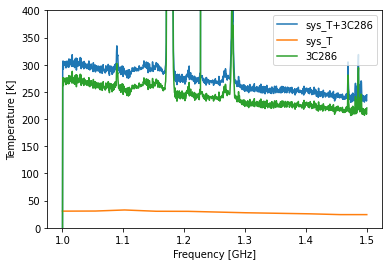

In [50]:
#3C286 flux density 
a0=1.2481
a1=-0.4507
a2=-0.1798
a3=0.0357
freq=filedata[0]['DAT_FREQ'][:]/1e3
s=10**(a0+a1*np.log10(freq)+a2*(np.log10(freq))**2+a3*(np.log10(freq))**3)

plt.plot(freq,np.mean(I_data,axis=0),label='sys_T+3C286')
plt.plot(freq,give_sys_T(30,freq*1000),label='sys_T')
plt.plot(freq,np.mean(I_data,axis=0)-give_sys_T(30,freq*1000),label='3C286')
plt.legend()
plt.ylim([0,400])
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')

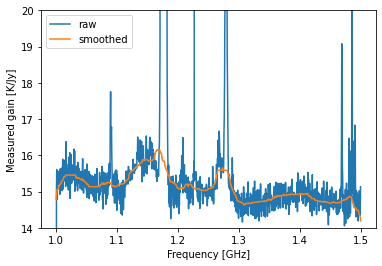

In [51]:
G=(np.mean(I_data,axis=0)-give_sys_T(30,freq*1000))/s
plt.plot(freq,G,label='raw')
freq0=[]
G0=[]
for i in range(1024):
    if 0<G[i]<17:
        freq0.append(freq[i])
        G0.append(G[i])
G1=np.interp(freq,freq0,G0)
G2=medfilt(G1,kernel_size=69)
plt.plot(freq,G2,label='smoothed')
plt.ylim([14,20])
plt.xlabel('Frequency [GHz]')
plt.ylabel('Measured gain [K/Jy]')
plt.legend()

In [52]:
np.save(file_dir+'G_cal.npy',G2)

In [34]:
date='1204'
file_dir="/Users/jiale/.mounty/Elements/PT2021_0019/"+date+"/"

filei=2
filename=file_dir+"3C286_arctracking-M01_"+str(filei+1).zfill(4)+".fits"
file=fits.open(filename)
header = file[0].header
filedata = file[1].data
ttbin=1024
[I_data,Q_data,U_data,V_data]=give_sp(filedata,ttbin)

cal_dir=file_dir+'high/'
noise_T=give_noise_T(cal_dir+'T_noise_W_high_01a.dat',cal_dir+'T_noise_W_high_01b.dat',cal_dir+'freq.dat',filedata[0]['DAT_FREQ'])

/var/folders/1_/z6r09nlj3wsf537lkrmrs2r00000gn/T/ipykernel_5142/3743102336.py:49: RuntimeWarning: invalid value encountered in arctanh
  gamma=np.arctanh(Q/I)/2


Text(0.5, 1.0, 'Gain')

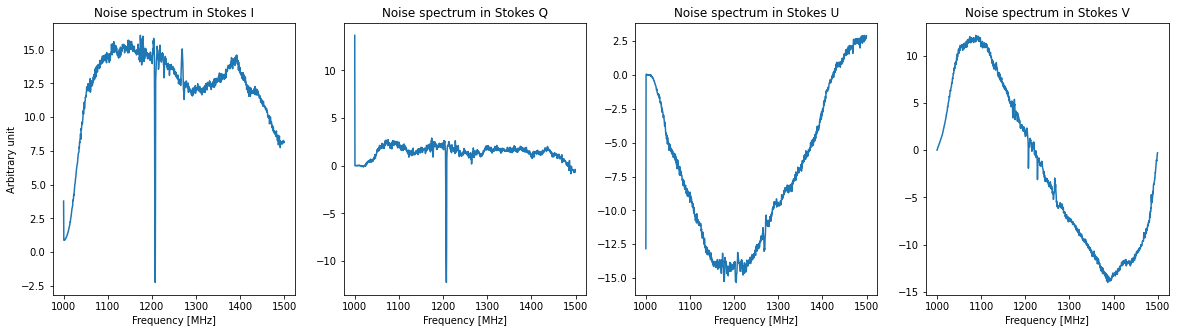

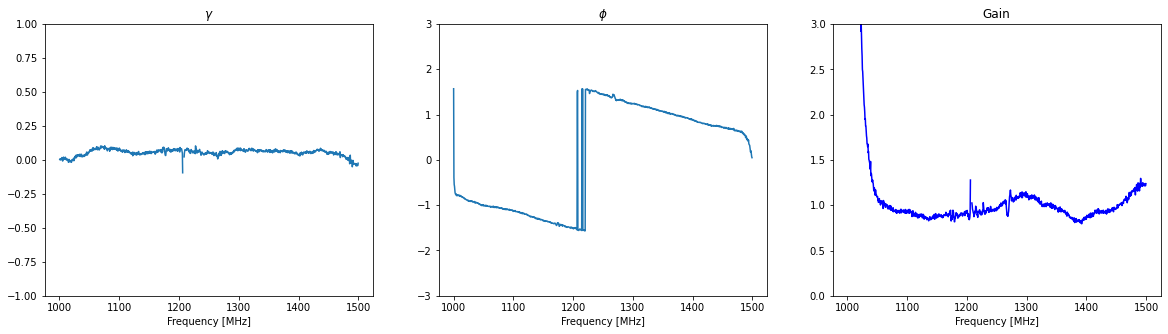

In [35]:
szdata=np.shape(I_data)
noise_num=noise_count(file=filei,currlen=szdata[0]*ttbin)
I_spec=np.zeros(szdata[1])
Q_spec=np.zeros(szdata[1])
U_spec=np.zeros(szdata[1])
V_spec=np.zeros(szdata[1])
for noise_i in range(noise_num):
    [noise_on,noise_off]=noise_onoff(noise_i,ttbin=ttbin,file=filei)
    I_spec_tmp=np.mean(I_data[noise_on[0]:noise_on[1],:],axis=0)-np.mean(I_data[noise_off[0]:noise_off[1],:],axis=0)
    Q_spec_tmp=np.mean(Q_data[noise_on[0]:noise_on[1],:],axis=0)-np.mean(Q_data[noise_off[0]:noise_off[1],:],axis=0)
    U_spec_tmp=np.mean(U_data[noise_on[0]:noise_on[1],:],axis=0)-np.mean(U_data[noise_off[0]:noise_off[1],:],axis=0)
    V_spec_tmp=np.mean(V_data[noise_on[0]:noise_on[1],:],axis=0)-np.mean(V_data[noise_off[0]:noise_off[1],:],axis=0)
    I_spec+=I_spec_tmp
    Q_spec+=Q_spec_tmp
    U_spec+=U_spec_tmp
    V_spec+=V_spec_tmp
    I_data[noise_on[0]:noise_on[1],:]-=I_spec_tmp
    Q_data[noise_on[0]:noise_on[1],:]-=Q_spec_tmp
    U_data[noise_on[0]:noise_on[1],:]-=U_spec_tmp
    V_data[noise_on[0]:noise_on[1],:]-=V_spec_tmp
[I_spec,Q_spec,U_spec,V_spec]=[I_spec/noise_num,Q_spec/noise_num,U_spec/noise_num,V_spec/noise_num]
[gamma,phi,au2t]=diff_cal(I_spec,Q_spec,U_spec,V_spec,noise_T=noise_T)
[I_data,Q_data,U_data,V_data]=obs2true(I_data,Q_data,U_data,V_data,gamma,phi,au2t)

plt.figure(1,figsize=(20,5))
plt.subplot(1,4,1)
plt.plot(filedata[0]['DAT_FREQ'][:],I_spec)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Arbitrary unit')
plt.title('Noise spectrum in Stokes I')

plt.subplot(1,4,2)
plt.plot(filedata[0]['DAT_FREQ'][:],Q_spec)
plt.xlabel('Frequency [MHz]')
plt.title('Noise spectrum in Stokes Q')

plt.subplot(1,4,3)
plt.plot(filedata[0]['DAT_FREQ'][:],U_spec)
plt.xlabel('Frequency [MHz]')
plt.title('Noise spectrum in Stokes U')

plt.subplot(1,4,4)
plt.plot(filedata[0]['DAT_FREQ'][:],V_spec)
plt.xlabel('Frequency [MHz]')
plt.title('Noise spectrum in Stokes V')

plt.figure(2,figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(filedata[0]['DAT_FREQ'][:],gamma)
plt.ylim([-1,1])
plt.xlabel('Frequency [MHz]')
plt.title('$\gamma$')

plt.subplot(1,3,2)
plt.plot(filedata[0]['DAT_FREQ'][:],phi)
plt.ylim([-3,3])
plt.xlabel('Frequency [MHz]')
plt.title('$\phi$')

plt.subplot(1,3,3)
plt.plot(filedata[0]['DAT_FREQ'][:],au2t,color='blue')
plt.ylim([0,3])
plt.xlabel('Frequency [MHz]')
plt.title('Gain')

Text(0, 0.5, 'Temperature [K]')

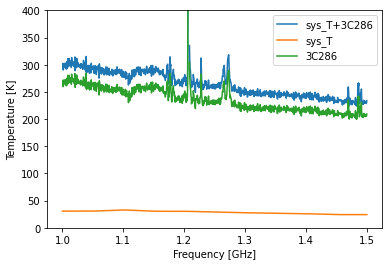

In [36]:
#3C286 flux density 
a0=1.2481
a1=-0.4507
a2=-0.1798
a3=0.0357
freq=filedata[0]['DAT_FREQ'][:]/1e3
s=10**(a0+a1*np.log10(freq)+a2*(np.log10(freq))**2+a3*(np.log10(freq))**3)

plt.plot(freq,np.mean(I_data,axis=0),label='sys_T+3C286')
plt.plot(freq,give_sys_T(30,freq*1000),label='sys_T')
plt.plot(freq,np.mean(I_data,axis=0)-give_sys_T(30,freq*1000),label='3C286')
plt.legend()
plt.ylim([0,400])
plt.xlabel('Frequency [GHz]')
plt.ylabel('Temperature [K]')

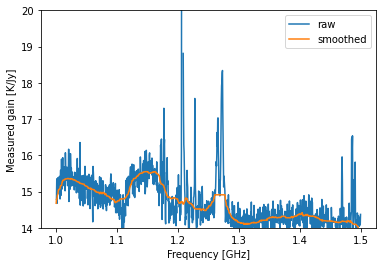

In [41]:
G=(np.mean(I_data,axis=0)-give_sys_T(30,freq*1000))/s
plt.plot(freq,G,label='raw')
freq0=[]
G0=[]
for i in range(1024):
    if 0<G[i]<17:
        freq0.append(freq[i])
        G0.append(G[i])
G1=np.interp(freq,freq0,G0)
G2=medfilt(G1,kernel_size=69)
plt.plot(freq,G2,label='smoothed')
plt.ylim([14,20])
plt.xlabel('Frequency [GHz]')
plt.ylabel('Measured gain [K/Jy]')
plt.legend()

In [45]:
np.save(file_dir+'G_cal.npy',G2)